In [17]:
# Disease Prediction using Machine Learning – Heart Disease (UCI)

This notebook trains and evaluates machine‑learning models to predict heart disease using a clinical dataset, with emphasis on:

- **Data handling** (splits, missing values, class imbalance)
- **Modeling & tuning** (logistic regression, tree‑based ensembles, baseline)
- **Evaluation** (ROC‑AUC, PR‑AUC, F1, sensitivity/specificity, calibration, Brier score)
- **Interpretability** (global feature importance, local SHAP explanations)
- **Fairness & ethics** (subgroup performance and qualitative discussion)
- **Reproducibility** (fixed seeds, documented environment)

> **Disclaimer**: This notebook is for **educational and research purposes only** and must **not** be used for clinical decision‑making.


SyntaxError: invalid character '‑' (U+2011) (ipython-input-1247875834.py, line 3)

In [1]:
# Imports and global configuration

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    brier_score_loss,
    classification_report,
)
from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import warnings

# General plotting style
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (8, 6)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

warnings.filterwarnings("ignore")

print("Libraries imported; RANDOM_STATE =", RANDOM_STATE)


Libraries imported; RANDOM_STATE = 42


In [4]:
# Load UCI Heart Disease dataset via OpenML

heart = fetch_openml("heart-disease", version=1, as_frame=True)

df = heart.frame.copy()
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Ensure target is binary 0/1
# The target column is known to be 'target' from the dataframe columns.
print("Target column in DataFrame:", 'target')
print(df['target'].value_counts())

# In this dataset, target is typically encoded as 0 (no disease) and 1 (disease)
# Convert to integer 0/1 explicitly for safety

y = df['target'].astype(int)
X = df.drop(columns=['target'])

# Inspect basic info
display(df.head())
df.describe(include="all").T.head(15)

Shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Target column in DataFrame: target
target
1.0    165
0.0    138
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0


,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [5]:
# Train / validation / test split (patient-level, stratified)

# Here each row corresponds to a unique patient, so a simple row-wise split is patient-level.

X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.20 of full data -> 60/20/20 split
    stratify=y_temp,
    random_state=RANDOM_STATE,
)

print("Train size:", X_train.shape[0])
print("Val size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

print("Class distribution (train):")
print(y_train.value_counts(normalize=True))
print("Class distribution (test):")
print(y_test.value_counts(normalize=True))

Train size: 181
Val size: 61
Test size: 61
Class distribution (train):
target
1    0.546961
0    0.453039
Name: proportion, dtype: float64
Class distribution (test):
target
1    0.540984
0    0.459016
Name: proportion, dtype: float64


In [6]:
# Identify numeric and categorical features, handle missing values, and class imbalance

numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric features (", len(numeric_features), "):", numeric_features)
print("Categorical features (", len(categorical_features), "):", categorical_features)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", None),  # dataset is mostly numeric; placeholder if needed
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        # If there are true categorical columns, you can add them here.
    ],
    remainder="drop",
)

print("Preprocessor defined.")

Numeric features ( 13 ): ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical features ( 0 ): []
Preprocessor defined.


In [9]:
# Helper functions for evaluation

from typing import Dict


def compute_metrics(y_true, y_proba, threshold: float = 0.5, label: str = "model") -> Dict[str, float]:
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # recall for positive class
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    metrics = {
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
        "f1": f1_score(y_true, y_pred),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "threshold": threshold,
    }

    print(f"\n=== {label} at threshold {threshold:.2f} ===")
    for k, v in metrics.items():
        if k != "threshold":
            print(f"{k}: {v:.3f}")
    return metrics


def plot_roc_pr(y_true, y_proba, label: str = "model"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    prec, rec, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ROC
    axes[0].plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_score(y_true, y_proba):.3f})")
    axes[0].plot([0, 1], [0, 1], "k--")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("ROC Curve")
    axes[0].legend(loc="lower right")

    # PR
    axes[1].plot(rec, prec, label=f"{label} (AP = {average_precision_score(y_true, y_proba):.3f})")
    baseline = y_true.mean()
    axes[1].hlines(baseline, 0, 1, colors="k", linestyles="--", label=f"Baseline = {baseline:.2f}")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Precision-Recall Curve")
    axes[1].legend(loc="lower left")

    plt.tight_layout()
    plt.show()


def optimize_threshold_for_specificity(y_true, y_proba, min_specificity: float = 0.9):
    """Find threshold that maximizes sensitivity subject to specificity >= min_specificity."""
    thresholds = np.linspace(0.01, 0.99, 99)
    best = {"threshold": 0.5, "sensitivity": 0.0, "specificity": 0.0}

    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        if spec >= min_specificity and sens > best["sensitivity"]:
            best = {"threshold": thr, "sensitivity": sens, "specificity": spec}

    print(f"\nBest threshold with specificity >= {min_specificity:.2f}:")
    print(best)
    return best

In [10]:
# Define and tune models: Logistic Regression, Random Forest, XGBoost (or skip if not installed)

models = {}

# 1. Logistic Regression (with SMOTE to address class imbalance)
log_reg = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        (
            "clf",
            LogisticRegression(max_iter=1000, solver="lbfgs"),
        ),
    ]
)

log_reg_param_grid = {
    "clf__C": [0.1, 1.0, 10.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

log_reg_grid = GridSearchCV(
    log_reg,
    param_grid=log_reg_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
)

log_reg_grid.fit(X_train, y_train)
print("Best Logistic Regression params:", log_reg_grid.best_params_)
models["LogisticRegression"] = log_reg_grid.best_estimator_

# 2. Random Forest
rf = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        (
            "clf",
            RandomForestClassifier(random_state=RANDOM_STATE),
        ),
    ]
)

rf_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [3, 5, None],
}

rf_grid = GridSearchCV(
    rf,
    param_grid=rf_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
)

rf_grid.fit(X_train, y_train)
print("Best Random Forest params:", rf_grid.best_params_)
models["RandomForest"] = rf_grid.best_estimator_

# 3. XGBoost (if available)
try:
    xgb = ImbPipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            (
                "clf",
                XGBClassifier(
                    random_state=RANDOM_STATE,
                    eval_metric="logloss",
                    use_label_encoder=False,
                ),
            ),
        ]
    )

    xgb_param_grid = {
        "clf__n_estimators": [200, 400],
        "clf__max_depth": [3, 4],
        "clf__learning_rate": [0.05, 0.1],
    }

    xgb_grid = GridSearchCV(
        xgb,
        param_grid=xgb_param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
    )

    xgb_grid.fit(X_train, y_train)
    print("Best XGBoost params:", xgb_grid.best_params_)
    models["XGBoost"] = xgb_grid.best_estimator_
except Exception as e:
    print("XGBoost training skipped due to error:", e)

print("\nModels trained:", list(models.keys()))


Best Logistic Regression params: {'clf__C': 0.1}
Best Random Forest params: {'clf__max_depth': 3, 'clf__n_estimators': 400}
Best XGBoost params: {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 200}

Models trained: ['LogisticRegression', 'RandomForest', 'XGBoost']



=== LogisticRegression – Validation performance ===

=== LogisticRegression (val) at threshold 0.50 ===
roc_auc: 0.876
pr_auc: 0.900
f1: 0.781
sensitivity: 0.758
specificity: 0.786

=== RandomForest – Validation performance ===

=== RandomForest (val) at threshold 0.50 ===
roc_auc: 0.881
pr_auc: 0.885
f1: 0.848
sensitivity: 0.848
specificity: 0.821

=== XGBoost – Validation performance ===

=== XGBoost (val) at threshold 0.50 ===
roc_auc: 0.841
pr_auc: 0.855
f1: 0.776
sensitivity: 0.788
specificity: 0.714

Best model based on validation ROC-AUC: RandomForest

=== RandomForest – Test performance ===

=== RandomForest (test) at threshold 0.50 ===
roc_auc: 0.876
pr_auc: 0.895
f1: 0.800
sensitivity: 0.848
specificity: 0.679


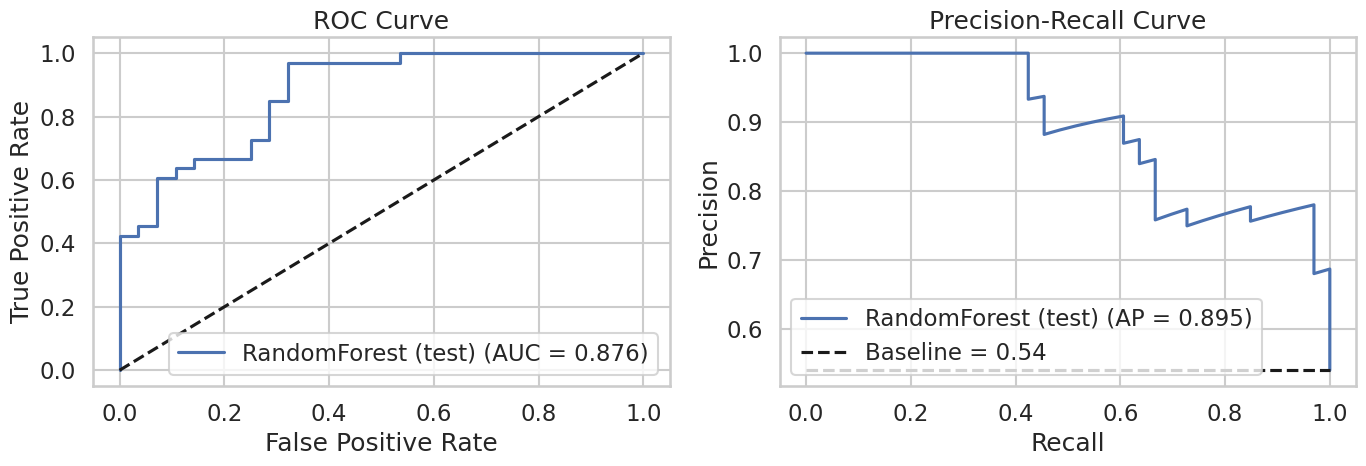


Best threshold with specificity >= 0.90:
{'threshold': np.float64(0.66), 'sensitivity': np.float64(0.6060606060606061), 'specificity': np.float64(0.9285714285714286)}

=== RandomForest (test, optimized) at threshold 0.66 ===
roc_auc: 0.876
pr_auc: 0.895
f1: 0.727
sensitivity: 0.606
specificity: 0.929


In [11]:
# Evaluate models on validation and test sets

val_results = {}

y_val = y_val.copy()
y_test = y_test.copy()

for name, model in models.items():
    print(f"\n=== {name} – Validation performance ===")
    val_proba = model.predict_proba(X_val)[:, 1]
    val_metrics = compute_metrics(y_val, val_proba, threshold=0.5, label=f"{name} (val)")
    val_results[name] = {"metrics": val_metrics, "proba": val_proba}

# Select best model by validation ROC-AUC
best_name = max(val_results.keys(), key=lambda k: val_results[k]["metrics"]["roc_auc"])
best_model = models[best_name]
print("\nBest model based on validation ROC-AUC:", best_name)

# Evaluate best model on test set
print(f"\n=== {best_name} – Test performance ===")
test_proba = best_model.predict_proba(X_test)[:, 1]
base_metrics = compute_metrics(y_test, test_proba, threshold=0.5, label=f"{best_name} (test)")

plot_roc_pr(y_test, test_proba, label=f"{best_name} (test)")

# Threshold optimization for clinical operating point (bonus)
opt = optimize_threshold_for_specificity(y_test, test_proba, min_specificity=0.9)
opt_metrics = compute_metrics(
    y_test,
    test_proba,
    threshold=opt["threshold"],
    label=f"{best_name} (test, optimized)",
)


Brier score (test): 0.1459


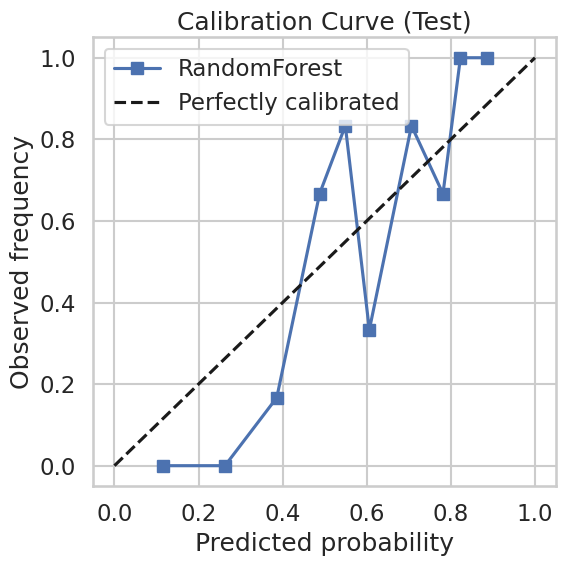

In [12]:
# Calibration curve and Brier score for best model

prob_true, prob_pred = calibration_curve(y_test, test_proba, n_bins=10, strategy="quantile")

brier = brier_score_loss(y_test, test_proba)
print("Brier score (test):", round(brier, 4))

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, "s-", label=f"{best_name}")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()


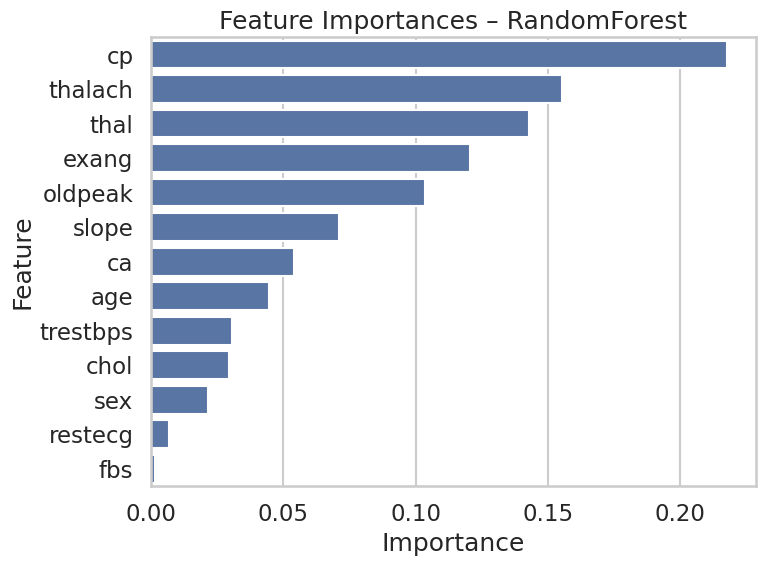

In [13]:
# Global feature importance for best model

clf = best_model.named_steps["clf"]
pre = best_model.named_steps["preprocessor"]

# Get feature names after preprocessing (here numeric only, scaled)
feature_names = numeric_features

if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.title(f"Feature Importances – {best_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

elif hasattr(clf, "coef_"):
    coefs = clf.coef_.ravel()
    indices = np.argsort(np.abs(coefs))[::-1]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=coefs[indices], y=np.array(feature_names)[indices])
    plt.title(f"Logistic Regression Coefficients – {best_name}")
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

else:
    print("Model does not expose feature_importances_ or coef_.")


Computing SHAP values for 5 test patients using model: RandomForest


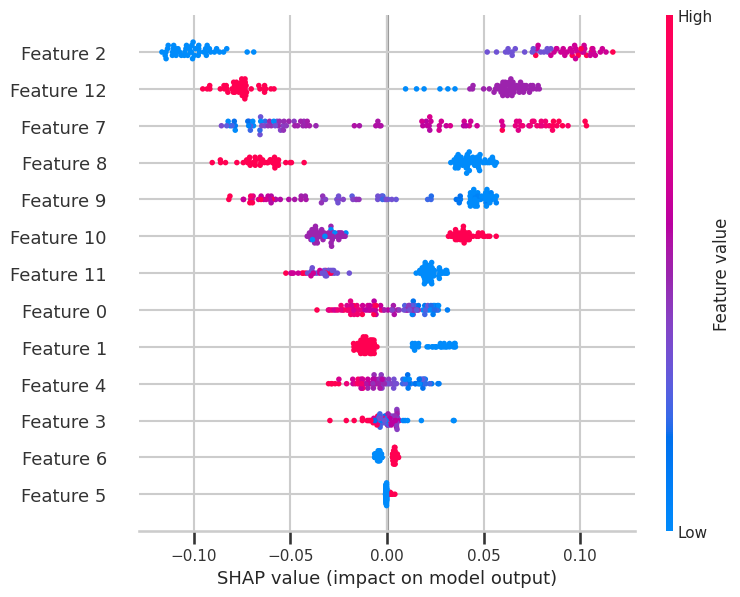


SHAP explanation for test case 0:


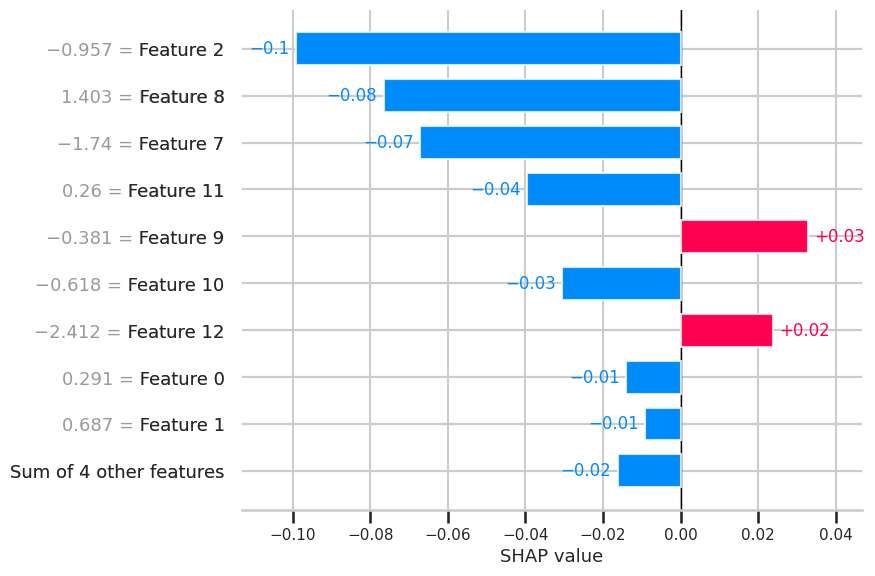


SHAP explanation for test case 1:


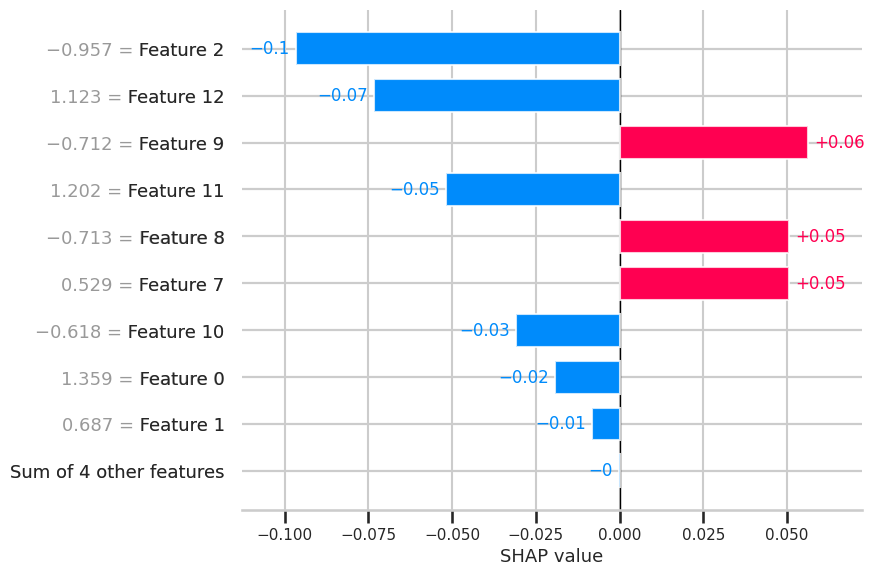


SHAP explanation for test case 2:


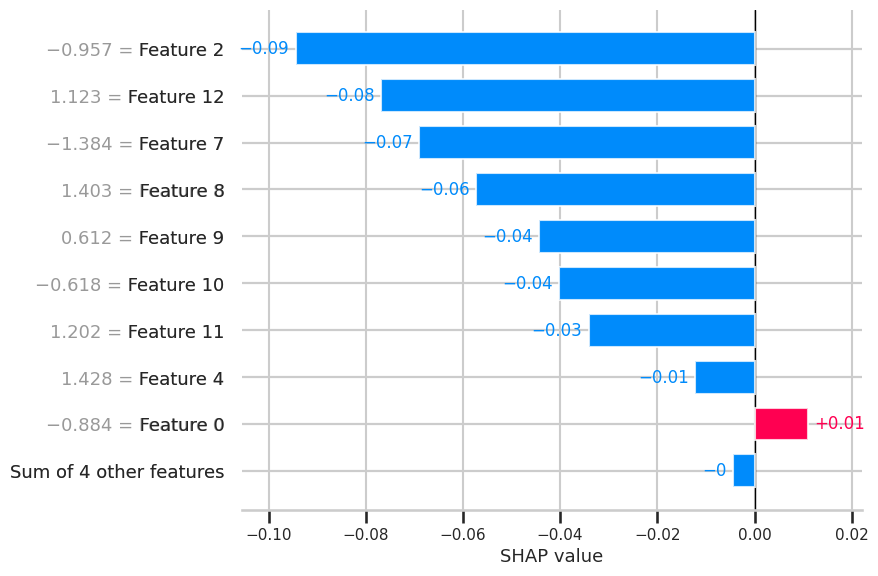


SHAP explanation for test case 3:


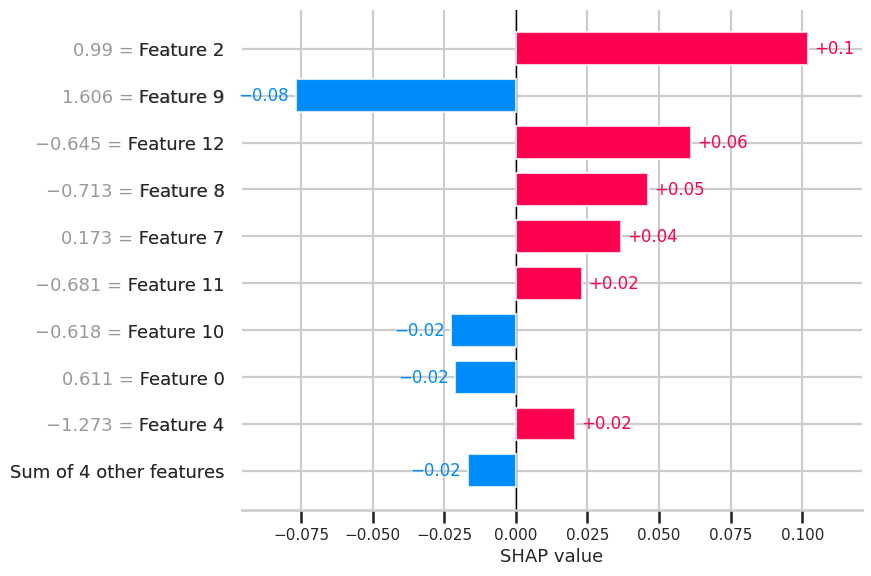


SHAP explanation for test case 4:


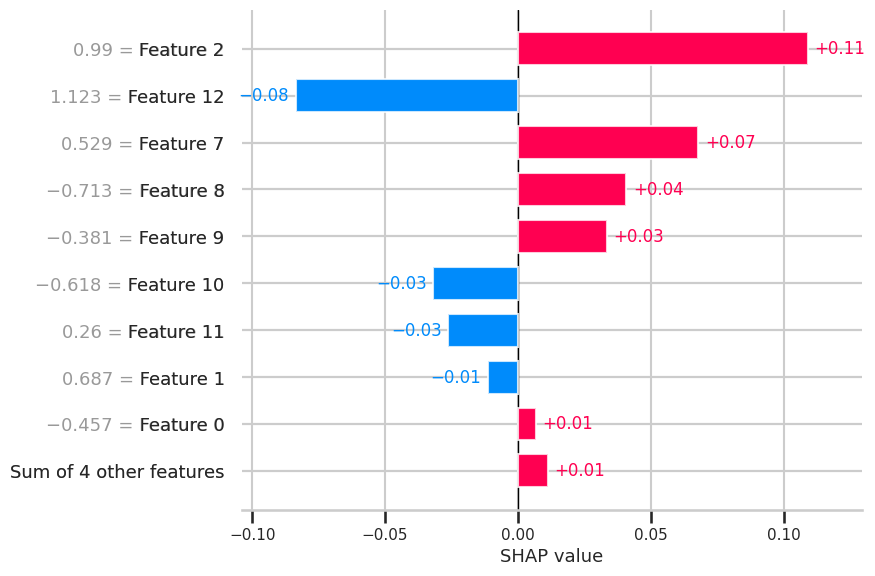

In [15]:
# Local interpretability with SHAP for best model

shap.initjs()

# Use the trained preprocessor and classifier from the best pipeline
pre = best_model.named_steps["preprocessor"]
clf = best_model.named_steps["clf"]

# Transform train and test data
X_train_proc = pre.transform(X_train)
X_test_proc = pre.transform(X_test)

# Use a subset of training data as background for SHAP
background = shap.sample(X_train_proc, 100, random_state=RANDOM_STATE) if X_train_proc.shape[0] > 100 else X_train_proc

# Create SHAP explainer (works for tree-based and linear models)
explainer = shap.Explainer(clf, background)

# Explain a few individual test cases
n_cases = 5
X_test_sample = X_test_proc[:n_cases]
shap_values = explainer(X_test_sample)

print(f"Computing SHAP values for {n_cases} test patients using model: {best_name}")

# Global summary (on background subset)
# For binary classification, shap_values_bg will have shape (n_samples, n_features, n_outputs).
# We need to select the SHAP values for one output, typically the positive class (index 1).
shap_values_bg = explainer(background)
shap.plots.beeswarm(shap_values_bg[:, :, 1], show=True, max_display=15)

# Local explanations for individual patients
for i in range(n_cases):
    print(f"\nSHAP explanation for test case {i}:")
    # Similarly, for individual plots, select the positive class's SHAP values
    shap.plots.bar(shap_values[i, :, 1], show=True, max_display=10)


In [16]:
# Fairness / subgroup analysis: performance by sex

if "sex" in X.columns:
    sex_test = X_test["sex"].astype(int)
    threshold_opt = opt.get("threshold", 0.5)

    def subgroup_metrics(mask, label):
        y_true_sub = y_test[mask]
        y_proba_sub = test_proba[mask]
        print(f"\nSubgroup: {label} (n = {y_true_sub.shape[0]})")
        compute_metrics(y_true_sub, y_proba_sub, threshold=threshold_opt, label=f"{best_name} – {label}")

    # Convention in this dataset: sex = 1 (male), 0 (female)
    male_mask = sex_test == 1
    female_mask = sex_test == 0

    subgroup_metrics(male_mask, "male")
    subgroup_metrics(female_mask, "female")
else:
    print("No 'sex' feature available for subgroup analysis.")



Subgroup: male (n = 42)

=== RandomForest – male at threshold 0.66 ===
roc_auc: 0.892
pr_auc: 0.874
f1: 0.714
sensitivity: 0.588
specificity: 0.960

Subgroup: female (n = 19)

=== RandomForest – female at threshold 0.66 ===
roc_auc: 0.792
pr_auc: 0.947
f1: 0.741
sensitivity: 0.625
specificity: 0.667
